In [1]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GATv2Conv

from types import SimpleNamespace

warnings.filterwarnings('ignore')

# Part1.以下为数据处理

In [2]:
df_features = pd.read_csv('elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv('elliptic_txs_edgelist.csv')
df_classes =  pd.read_csv('elliptic_txs_classes.csv')
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})
# 将类别数据映射到数值。这里将"unknown"映射到2，"1"映射到1，"2"映射到0。

In [3]:
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
# 将特征数据框（df_features）和类别数据框（df_classes）合并。
# 使用左连接（left join），以特征数据框为基础，根据交易ID（txId）进行匹配。
df_merge = df_merge.sort_values(0).reset_index(drop=True)
# 对合并后的数据框按照交易ID（第0列）进行排序，并重置索引。

In [4]:
# 创建一个映射，将每个交易ID映射到一个唯一的索引。
# 这在图数据中常见，因为图神经网络通常需要以整数索引来表示节点。
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)}

# 将边数据框（df_edges）中的交易ID映射到之前创建的索引。
# 这确保了边数据框中的交易ID与节点数据框中的索引对应。
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# 创建一个权重张量，其中所有边的权重都设为1。
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)
# 打印有向无环图（DAG）中边的总数。
print("Total amount of edges in DAG:", edge_index.shape)

Total amount of edges in DAG: torch.Size([2, 234355])


In [5]:
# 从合并后的数据框中去除'txId'列，因为我们已经有了映射到索引的交易ID。
node_features = df_merge.drop(['txId'], axis=1).copy()
# 将节点特征中的交易ID映射到对应的索引。
node_features[0] = node_features[0].map(map_id)

# 根据类别标签区分已分类（'class'不是2）和未分类（'class'是2）的节点，
# 并分别存储它们的索引。
classified_idx = node_features['class'].loc[node_features['class'] != 2].index
unclassified_idx = node_features['class'].loc[node_features['class'] == 2].index

# 将未知类别（之前映射为2）替换为0。这是为了避免在训练时处理三个类别。
# 在这个上下文中，未知类别的数据不会用于预训练。

node_features['class'] = node_features['class'].replace(2, 0)

labels = node_features['class'].values

# 从节点特征中去除索引、类别和时间轴
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)

In [6]:
# 使用PyTorch Geometric的Data类创建图数据对象。
# 'x'为节点特征，'edge_index'为边的索引，'edge_attr'为边的属性（在此例中是权重），
# 'y'为节点的标签。
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32))

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 203769
Number of node features: 165
Number of edges: 234355
Number of edge features: 165
Average node degree: 1.15
Number of classes: 2
Has isolated nodes: False
Has self loops: False
Is directed: True


In [7]:
from types import SimpleNamespace

config = SimpleNamespace(
    seed = 0,
    learning_rate = 0.001,
    weight_decay = 1e-5,# weight_decay：权重衰减，用于正则化以防止过拟合。
    input_dim = 165,
    output_dim = 1,
    hidden_size = 128,
    num_epochs = 200,
    checkpoints_dir = './models/elliptic_gnn',
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

print("Using device:", config.device)


Using device: cuda


In [8]:
y_train = labels[classified_idx]

# 使用train_test_split函数将已分类的节点分割成训练集和验证集。
# test_size=0.15 表示验证集占15%，剩余85%作为训练集。
# random_state 设置为配置中的种子，以确保可重复性。
# stratify 参数确保训练集和验证集在类别分布上保持一致。
_, _, _, _, train_idx, valid_idx = train_test_split(node_features[classified_idx],
                                                    y_train,
                                                    classified_idx,
                                                    test_size=0.15,
                                                    random_state=config.seed,
                                                    stratify=y_train)
# 将训练集、验证集和测试集的索引分别转换为PyTorch张量，并存储在elliptic_dataset对象中。
elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 39579
Validation dataset size: 6985
Test dataset size: 157205


# Part2.以下为监督学习部分

## 结合图注意力机制的自编码器——定义

In [9]:
def accuracy(y_pred, y_test, prediction_threshold=0.5):
    device = y_pred.device  # 获取预测的设备
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()
    y_test = y_test.to(device)  # 将目标移动到同一设备
    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

# 包含两个注意力层（gat1 和 gat2），用于处理图数据。
# gat1 用于输入层，gat2_class 和 gat2_feature 用于输出层，分别用于分类和特征表示。
class GAT(torch.nn.Module):
    """Graph Attention Network with dual output for classification and feature representation."""
    def __init__(self, dim_in, dim_h, dim_out, dim_feature, heads=8):
        super(GAT, self).__init__()
        self.norm1 = BatchNorm1d(dim_in)
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.3)
        self.norm2 = BatchNorm1d(dim_h*heads)
        # 分类头
        self.gat2_class = GATv2Conv(dim_h*heads, dim_out, heads=heads, concat=False, dropout=0.6)
        # 特征头
        self.gat2_feature = GATv2Conv(dim_h*heads, dim_feature, heads=heads, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        # 分类输出
        out_class = self.gat2_class(h, edge_index)
        # 特征输出
        out_feature = self.gat2_feature(h, edge_index)
        return out_class, out_feature
    
# 定义一个完全连接的解码器类。
# 包含一个线性层，用于解码特征表示。
class FullyConnectedDecoder(torch.nn.Module):
    def __init__(self, dim_feature, dim_out=165):
        super(FullyConnectedDecoder, self).__init__()
        # 可以增加更多的层或使用不同的层结构来调整解码器的复杂性
        self.fc1 = torch.nn.Linear(dim_feature, dim_out)

    def forward(self, x):
        x = self.fc1(x)
        return x
    
# 定义一个GAT自编码器类。
# 结合了前面定义的GAT和完全连接的解码器，用于同时进行分类和特征重构。 
# 定义GAT自编码器类
# 该类结合了前面定义的GAT和完全连接的解码器，用于同时进行分类和特征重构
class GATAutoencoder(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, dim_feature, heads=8):
        super(GATAutoencoder, self).__init__()
        self.encoder = GAT(dim_in, dim_h, dim_out, dim_feature, heads)
        self.decoder = FullyConnectedDecoder(dim_feature, 165)  # 确保解码器的输出维度是原始数据的维度

    def forward(self, x, edge_index):
        out_class, out_feature = self.encoder(x, edge_index)  # 编码器输出分类和特征表示
        reconstructed = self.decoder(out_feature)  # 解码器重构特征
        return out_class, reconstructed, out_feature  # 返回分类结果，重构结果，和特征表示


## 训练和评估函数的定义

In [37]:
def train_evaluate(model, data, criterion_class, criterion_recon, optimizer, config):
    best_model_wts = copy.deepcopy(model.state_dict())  # 复制模型的初始状态
    best_loss = float('inf')  # 初始化最佳损失为无限大

    if not os.path.exists(config.checkpoints_dir):  # 检查是否存在检查点目录
        os.makedirs(config.checkpoints_dir)  # 如果不存在，创建目录

    for epoch in range(config.num_epochs + 1):  # 对每个训练周期进行迭代
        model.train()  # 设置模型为训练模式
        optimizer.zero_grad()  # 清零梯度
        # 前向传播：计算类别输出、重建输出和特征表示
        out_class, reconstructed, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))
        # 计算类别损失
        loss_class = criterion_class(out_class[data.train_idx], data.y[data.train_idx].to(config.device).unsqueeze(1))
        # 计算重建损失
        loss_recon = criterion_recon(reconstructed[data.train_idx], data.x[data.train_idx].to(config.device))
        loss = loss_class + loss_recon  # 组合损失
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新模型参数

        # 验证
        model.eval()  # 设置模型为评估模式
        with torch.no_grad():  # 不计算梯度，减少计算和内存使用
            out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
            # 计算验证损失
            val_loss = criterion_class(out_class[data.val_idx], data.y[data.val_idx].to(config.device).unsqueeze(1))

        if epoch % 10 == 0:  # 每10个周期打印一次进度
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val Loss: {val_loss:.4f}')

            if val_loss < best_loss:  # 如果当前验证损失小于之前的最佳损失
                best_loss = val_loss  # 更新最佳损失
                print("Saving model with best loss")  # 打印保存模型信息
                checkpoint = {'state_dict': model.state_dict()}  # 保存模型状态
                # 在每个epoch后保存模型，文件名包含epoch信息
                torch.save(model.state_dict(), os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_{epoch}.pth'))


    return model  # 返回训练好的模型


# 定义一个在测试数据上运行模型的函数
# 这个函数加载之前保存的最佳模型，并在测试数据上进行预测
def test(model, data, config):
    model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_{config.num_epochs}.pth')))

    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 不计算梯度
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))  # 接收所有返回值
        preds = ((torch.sigmoid(out_class) > 0.5).float()).squeeze(1)  # 计算预测值
    return preds  # 返回预测值

## 自编码器预训练

In [44]:
torch.manual_seed(config.seed)
config.hidden_size = 64  # 减小隐藏层大小
config.dim_feature = 64  # 减小特征头输出维度
config.heads = 8        # 减少注意力头的数量
config.num_epochs = 320
# 创建模型实例
autoencoder_model = GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.hidden_size, config.heads).to(config.device)

In [12]:

# 创建优化器和损失函数
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion_class = torch.nn.BCEWithLogitsLoss()
# 创建二元交叉熵损失函数，用于分类任务。
criterion_recon = torch.nn.MSELoss()
# 创建均方误差损失函数，用于重构任务。

# 训练和评估模型
trained_model = train_evaluate(autoencoder_model, elliptic_dataset, criterion_class, criterion_recon, optimizer, config)


Epoch   0 | Train Loss: 3.120 | Val Loss: 0.5768
Saving model with best loss
Epoch  10 | Train Loss: 2.231 | Val Loss: 0.2658
Saving model with best loss
Epoch  20 | Train Loss: 1.945 | Val Loss: 0.2234
Saving model with best loss
Epoch  30 | Train Loss: 1.701 | Val Loss: 0.2091
Saving model with best loss
Epoch  40 | Train Loss: 1.562 | Val Loss: 0.1981
Saving model with best loss
Epoch  50 | Train Loss: 1.409 | Val Loss: 0.1898
Saving model with best loss
Epoch  60 | Train Loss: 1.316 | Val Loss: 0.1833
Saving model with best loss
Epoch  70 | Train Loss: 1.228 | Val Loss: 0.1771
Saving model with best loss
Epoch  80 | Train Loss: 1.144 | Val Loss: 0.1704
Saving model with best loss
Epoch  90 | Train Loss: 1.070 | Val Loss: 0.1633
Saving model with best loss
Epoch 100 | Train Loss: 1.033 | Val Loss: 0.1569
Saving model with best loss


## 结果可视化

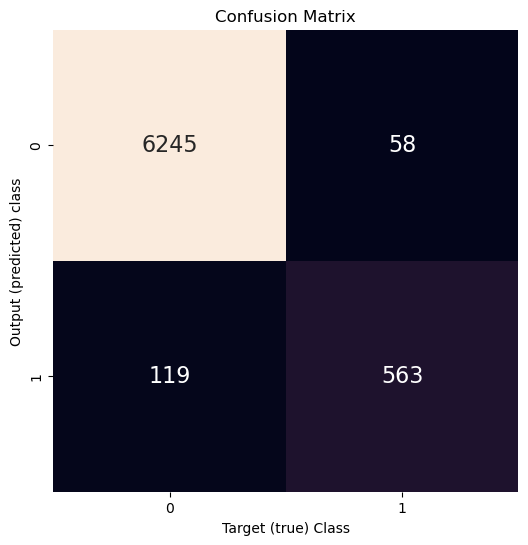

              precision    recall  f1-score   support

       licit     0.9813    0.9908    0.9860      6303
     illicit     0.9066    0.8255    0.8642       682

    accuracy                         0.9747      6985
   macro avg     0.9440    0.9082    0.9251      6985
weighted avg     0.9740    0.9747    0.9741      6985



In [45]:
trained_model=GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.hidden_size, config.heads).to(config.device)
y_test_preds = test(trained_model, elliptic_dataset, config)

# 混淆矩阵
conf_mat = confusion_matrix(elliptic_dataset.y[elliptic_dataset.val_idx].detach().cpu().numpy(), y_test_preds[elliptic_dataset.val_idx].cpu())
# 生成混淆矩阵。这个矩阵展示了模型在验证集上的预测结果与实际标签之间的关系。

plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class')
plt.ylabel('Output (predicted) class')
plt.title('Confusion Matrix')
plt.show()
# 混淆矩阵的每个单元格显示实际类别与预测类别的匹配程度。

# 分类报告
print(classification_report(elliptic_dataset.y[elliptic_dataset.val_idx].detach().cpu().numpy(), y_test_preds[elliptic_dataset.val_idx].cpu(), target_names=['licit', 'illicit'],digits=4))
# 这个报告提供了模型在各个类别上的精确度、召回率、F1分数等指标。

# Part3.以下是半监督学习部分（充分利用无标签数据,引入生成对抗网络，进一步增强编码器的能力）

## 以下是模型的定义

In [21]:
## 定义特征判别器
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),  # 假设输入是一个概率值
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),  # 加入Dropout防止过拟合
            nn.Linear(32, 1),
            nn.Sigmoid()  # 输出一个概率，表示输入为真实标签的概率
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 确保输入是正确的形状
        return self.model(x)

In [22]:
class FeatureDiscriminator(torch.nn.Module):
    def __init__(self, feature_dim):
        super(FeatureDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 128),  # feature_dim是特征表示的维度
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),  # 加入Dropout防止过拟合
            nn.Linear(64, 1),
            nn.Sigmoid()  # 输出一个概率，表示输入为真实特征表示的概率
        )

    def forward(self, features):
        return self.model(features)


## 定义新的训练评估函数

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

def train_evaluate(model, discriminator, feature_discriminator, data, criterion_class, criterion_recon, optimizer, optimizer_D, optimizer_FD, config):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    pca = PCA(n_components=64)
    real_feature_data = pca.fit_transform(data.x.detach().cpu().numpy())
    real_feature_data = torch.tensor(real_feature_data, device=config.device, dtype=torch.float32)

    criterion_D = torch.nn.BCELoss()
    criterion_FD = torch.nn.BCELoss()

    for epoch in range(config.num_epochs + 1):
        model.train()
        discriminator.train()
        feature_discriminator.train()

        optimizer.zero_grad()

        out_class, reconstructed, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))

        loss_class = criterion_class(out_class[data.train_idx], data.y[data.train_idx].to(config.device).unsqueeze(1))
        fake_data = out_class.detach()
        fake_labels = torch.ones(fake_data.size(0), 1, device=config.device)

        optimizer_D.zero_grad()
        real_data = data.y[data.train_idx].to(config.device).unsqueeze(1)
        real_loss = criterion_D(discriminator(real_data), torch.ones(real_data.size(0), 1, device=config.device))
        fake_loss = criterion_D(discriminator(fake_data), torch.zeros(fake_data.size(0), 1, device=config.device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        optimizer_FD.zero_grad()
        real_feature_loss = criterion_FD(feature_discriminator(real_feature_data), torch.ones(real_feature_data.size(0), 1, device=config.device))
        fake_feature_loss = criterion_FD(feature_discriminator(out_feature.detach()), torch.zeros(out_feature.size(0), 1, device=config.device))
        fd_loss = (real_feature_loss + fake_feature_loss) / 2
        fd_loss.backward()
        optimizer_FD.step()

        fake_labels = torch.ones(fake_data.size(0), 1, device=config.device)
        # 设置权重
        weight_class = 0.3   # 你可以调整这些权重以找到最优的训练平衡
        weight_discriminator = 0.4
        weight_feature_discriminator = 0.3

        # 计算加权损失
        g_loss = (weight_class * loss_class +
          weight_discriminator * criterion_D(discriminator(fake_data), fake_labels) +
          weight_feature_discriminator * criterion_FD(feature_discriminator(out_feature.detach()), torch.ones(out_feature.size(0), 1, device=config.device)))
    
        g_loss.backward(retain_graph=True)
        optimizer.step()
        
        
        if epoch % 10 == 0 or epoch == config.num_epochs:
            val_loss = evaluate(model, discriminator, feature_discriminator, data, criterion_class, criterion_D, criterion_FD, config)
            print(f'Epoch {epoch:>3} | Train Loss: {g_loss.item():.3f}| Train Loss: {loss_class.item():.3f} | D Loss: {d_loss.item():.3f} | FD Loss: {fd_loss.item():.3f} | Val Loss: {val_loss:.3f}')
            if val_loss < best_loss:
                print("Saving model with best validation loss")
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f'{config.checkpoints_dir}/best2_model_epoch_{epoch}.pth')

    model.load_state_dict(best_model_wts)
    return model

def evaluate(model, discriminator, feature_discriminator, data, criterion_class, criterion_D, criterion_FD, config):
    model.eval()
    discriminator.eval()
    feature_discriminator.eval()
    with torch.no_grad():
        out_class, _, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))
        val_loss = criterion_class(out_class[data.val_idx], data.y[data.val_idx].to(config.device).unsqueeze(1)).item()
    return val_loss

def test(model, data, config):

    model_path = os.path.join(config.checkpoints_dir, f'best2_model_epoch_{config.num_epochs}.pth')
    model.load_state_dict(torch.load(model_path))
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        preds = ((torch.sigmoid(out_class) > 0.5).float()).squeeze(1)
    return preds


In [24]:

# 加载预训练的自编码器模型
best_epoch = config.num_epochs  # 或其他特定的epoch值
autoencoder_model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_{best_epoch}.pth')))

<All keys matched successfully>

## 训练

In [19]:
config.num_epochs = 200

# 定义标签和特征判别器及其优化器
label_discriminator = Discriminator().to(config.device)
feature_discriminator = FeatureDiscriminator(feature_dim=config.dim_feature).to(config.device)

optimizer_label_D = Adam(label_discriminator.parameters(), lr=0.001)
optimizer_feature_D = Adam(feature_discriminator.parameters(), lr=0.001)

# 自编码器的优化器和损失函数
optimizer = Adam(autoencoder_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion_class = nn.BCEWithLogitsLoss()
criterion_recon = nn.MSELoss()

# 开始训练
trained_model = train_evaluate(autoencoder_model, label_discriminator, feature_discriminator, elliptic_dataset, criterion_class, criterion_recon, optimizer, optimizer_label_D, optimizer_feature_D, config)

Epoch   0 | Train Loss: 0.549| Train Loss: 0.179 | D Loss: 0.750 | FD Loss: 0.705 | Val Loss: 0.154
Saving model with best validation loss
Epoch  10 | Train Loss: 0.895| Train Loss: 0.152 | D Loss: 0.528 | FD Loss: 0.597 | Val Loss: 0.130
Saving model with best validation loss
Epoch  20 | Train Loss: 1.490| Train Loss: 0.134 | D Loss: 0.435 | FD Loss: 0.474 | Val Loss: 0.114
Saving model with best validation loss
Epoch  30 | Train Loss: 2.234| Train Loss: 0.123 | D Loss: 0.379 | FD Loss: 0.328 | Val Loss: 0.104
Saving model with best validation loss
Epoch  40 | Train Loss: 2.988| Train Loss: 0.114 | D Loss: 0.338 | FD Loss: 0.198 | Val Loss: 0.096
Saving model with best validation loss
Epoch  50 | Train Loss: 3.811| Train Loss: 0.105 | D Loss: 0.306 | FD Loss: 0.106 | Val Loss: 0.091
Saving model with best validation loss
Epoch  60 | Train Loss: 4.722| Train Loss: 0.098 | D Loss: 0.279 | FD Loss: 0.058 | Val Loss: 0.086
Saving model with best validation loss
Epoch  70 | Train Loss: 5.5

## 可视化

In [31]:
def test(model, data, config):

    model_path = os.path.join(config.checkpoints_dir, f'best2_model_epoch_200.pth')
    model.load_state_dict(torch.load(model_path))
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        preds = ((torch.sigmoid(out_class) > 0.5).float()).squeeze(1)
    return preds

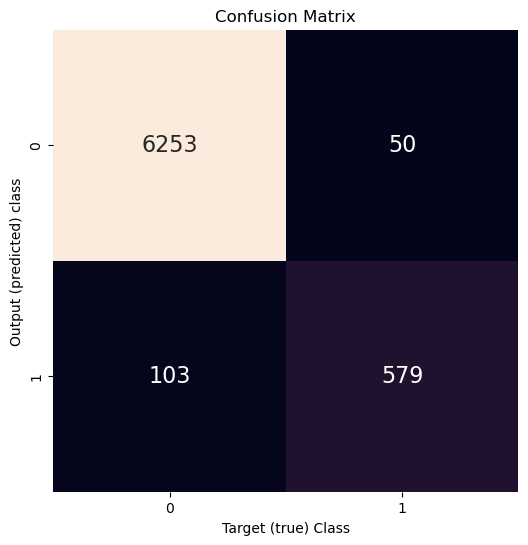

              precision    recall  f1-score   support

       licit     0.9838    0.9921    0.9879      6303
     illicit     0.9205    0.8490    0.8833       682

    accuracy                         0.9781      6985
   macro avg     0.9522    0.9205    0.9356      6985
weighted avg     0.9776    0.9781    0.9777      6985



In [33]:
trained_model=GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.hidden_size, config.heads).to(config.device)
y_test_preds = test(trained_model, elliptic_dataset, config)

# 混淆矩阵
conf_mat = confusion_matrix(elliptic_dataset.y[elliptic_dataset.val_idx].detach().cpu().numpy(), y_test_preds[elliptic_dataset.val_idx].cpu())
# 生成混淆矩阵。这个矩阵展示了模型在验证集上的预测结果与实际标签之间的关系。

plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class')
plt.ylabel('Output (predicted) class')
plt.title('Confusion Matrix')
plt.show()
# 混淆矩阵的每个单元格显示实际类别与预测类别的匹配程度。

# 分类报告
print(classification_report(elliptic_dataset.y[elliptic_dataset.val_idx].detach().cpu().numpy(), y_test_preds[elliptic_dataset.val_idx].cpu(), target_names=['licit', 'illicit'],digits=4))
# 这个报告提供了模型在各个类别上的精确度、召回率、F1分数等指标。